# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads the 5 files that contain the dataset and the checkpoint:


https://drive.google.com/open?id=1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh

https://drive.google.com/open?id=18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv

https://drive.google.com/open?id=1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz

https://drive.google.com/open?id=1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a

https://drive.google.com/open?id=1fZY-tP2MuUYCA7Ur0C0zGTfEBs1XswGQ

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW3b')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
'1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh': 'hw3_mycocodata_bboxes_comp_zlib.npy',
'18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv': 'hw3_mycocodata_img_comp_zlib.h5',
'1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz': 'hw3_mycocodata_labels_comp_zlib.npy',
'1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a': 'hw3_mycocodata_mask_comp_zlib.h5',
'1fZY-tP2MuUYCA7Ur0C0zGTfEBs1XswGQ': 'checkpoint680.pth',
}

# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

Mounted at /content/gdrive


In [0]:
import numpy as np
import h5py
import torch
import torchvision
from matplotlib import pyplot as plt
from pdb import set_trace as debug
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.ticker as plticker
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import cv2
from skimage.transform import resize
from torchvision.models.detection.image_list import ImageList
from collections import OrderedDict
import copy
from scipy.special import softmax
import torchvision
from PIL import Image

In [0]:
np.random.seed(9)
torch.manual_seed(9)

In [0]:
## Load Data
## Pad images
def organize_mask(labels, masks):
  all_mask =[]
  j = 0
  
  for i in range(len(labels)):
    mask_ = []
 
    len_label = len(labels[i])
    # debug()
    if len_label > 1:
      # for k in range(len_label):
      all_mask.append(masks[j:j+len_label])
    else:
      all_mask.append(np.asarray([masks[j]]))
    j = j + len_label
    # all_mask.append(mask_)
  # debug()
  return np.array(all_mask)

In [0]:
def load_data():
  all_images_h5 = h5py.File('./hw3_mycocodata_img_comp_zlib.h5')
  all_image_data = all_images_h5.get(f'{list(all_images_h5.keys())[0]}').value

  all_mask_h5 = h5py.File('./hw3_mycocodata_mask_comp_zlib.h5')
  all_mask_data = all_mask_h5.get(f'{list(all_mask_h5.keys())[0]}').value

  all_bbox_data = np.load('./hw3_mycocodata_bboxes_comp_zlib.npy', allow_pickle=True)

  all_label_data = np.load('./hw3_mycocodata_labels_comp_zlib.npy', allow_pickle=True)

  struct_mask = organize_mask(all_label_data, all_mask_data)
  permute_index = np.arange(len(all_image_data))
  np.random.shuffle(permute_index)
  train_N = int(len(all_image_data)*0.85)

  train_ind, test_ind = permute_index[:train_N], permute_index[train_N:]

  train_image = all_image_data[train_ind]
  test_image = all_image_data[test_ind]

  train_mask = struct_mask[train_ind]
  test_mask = struct_mask[test_ind]

  train_bbox = all_bbox_data[train_ind]
  test_bbox = all_bbox_data[test_ind]

  train_label = all_label_data[train_ind]
  test_label = all_label_data[test_ind]

  return train_image, test_image, train_bbox, test_bbox, train_label, test_label, train_mask, test_mask

In [0]:
train_image, test_image, train_bbox, test_bbox, train_label, test_label, train_mask, test_mask = load_data()

In [0]:
def check_plot(im, bbox, mask, norm = False):
  if norm:
    plt.imshow((np.clip(im, a_min = 0, a_max=1)))
    # debug()
  else:
    plt.imshow(im)
  
  ax = plt.gca()
  # debug()
  for i in range(len(mask)):
    rect = Rectangle((bbox[i,0],bbox[i,1]),
                     bbox[i,2] - bbox[i,0],
                     bbox[i,3] - bbox[i,1],
                     linewidth=2,edgecolor='r',facecolor='none'
                     )
    ax.add_patch(rect)
  for j in range(len(mask)):
    plt.figure()
    plt.imshow(mask[j].astype(np.uint8))
    plt.show()

def normalize(ima, mean = np.array([0.485, 0.456, 0.406]), std = np.array([0.229, 0.224, 0.225])):

  return (ima - mean)/std


def resize_pad(im, bbox, mask,pad_col = 1088, pad_row = 800, transpose = True, Normalize = True):
  if im.shape[0] == 1:
    im = im.squeeze(0)
  
  if len(im.shape) <= 3:
    if transpose:
      im = np.transpose(im, (1, 2, 0))
    if Normalize:
      im = im / 255.0
      im = normalize(im)
    Row, Col, Chan = im.shape
    aspect = Col/Row
    new_Row = pad_row
    new_Col = pad_row*aspect
    new_Col_int = int(new_Col)
    im1 = cv2.resize(im.copy(),(new_Col_int, new_Row))
    

    im1 = np.pad(im1, ((0, 0), (int((pad_col - new_Col_int)/2), int((pad_col - new_Col_int)/2)),
                      (0,0)))

    mask_loop = np.empty([len(mask), pad_row, pad_col])

    for i in range(len(mask)):
      mask1 = cv2.resize(mask[i].copy().astype(np.uint8),(new_Col_int, new_Row))
      mask1 = np.pad(mask1, ((0, 0), (int((pad_col - new_Col_int)/2), int((pad_col - new_Col_int)/2)),
                    ))
      mask_loop[i] = mask1.astype(np.uint8)

    bbox1 = bbox*np.array([new_Col/Col, new_Row/Row, new_Col/Col, new_Row/Row])
    bbox1 = bbox1 + np.array([int((pad_col - new_Col_int)/2), 0, 
                                   int((pad_col - new_Col_int)/2), 0])

    return np.transpose(im1.astype(np.float32), (2, 0, 1)), bbox1, mask_loop

  

In [0]:
def plot_rpn(rpn_image, rpn_out):
  ## choose 5 random proposals

  if rpn_image.shape[0] == 1:
    rpn_image = rpn_image.squeeze(0)
  rpn_out = rpn_out[0][0]
  index = np.random.choice(len(rpn_out), 5, replace=False)

  index = [0,1,2,3]

  actual_label = rpn_out[index].cpu().numpy()


  if isinstance(rpn_image, torch.Tensor):

    test_image = rpn_image.cpu().numpy()
    test_image = np.transpose(test_image, (1,2,0))

  else:
    test_image = rpn_image.copy()
  plt.figure(figsize = (7,10))
  plt.imshow(test_image, interpolation='nearest')

  ax = plt.gca()


  for i in range(len(actual_label)):

    rect = Rectangle((actual_label[i,0],actual_label[i,1]),
                     actual_label[i,2] - actual_label[i,0],
                     actual_label[i,3] - actual_label[i,1],
                     linewidth=2,edgecolor='r',facecolor='none'
                     )


    ax.add_patch(rect)
  plt.show()

# PyTorch Dataset

Copy your HW3a dataset code

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
def my_collate(batch):
  data = [item[0].unsqueeze(0) for item in batch]
  
  list_shape = [tuple(item[0].shape[1:]) for item in batch]
  target = [item[1] for item in batch]
  bbox = [item[2] for item in batch]
  mask = [item[3] for item in batch]
  return [data, list_shape, target, bbox, mask]
  
class HW3Dataset(torch.utils.data.Dataset):
  def __init__(self, image_file, label_file, bbox_file, mask_file,transform = None, device = 'cpu'):
    assert isinstance(image_file, np.ndarray) and isinstance(image_file, np.ndarray), 'image_file and label_file should be of numpy array format'
    assert len(image_file) == len(label_file), 'images and labels are differnt sizes'
    
    self.device = device
    self.images = image_file
    self.labels = label_file
    self.actual_bbox = bbox_file
    self.mask = mask_file
    self.transform = transform
    
  def __len__(self):
    return len(self.images)
     
  def __getitem__(self, index):
    sample_image = self.images[index]
    sample_label = self.labels[index]
    sample_box = self.actual_bbox[index]
    sample_mask = self.mask[index]
    sample_image1, sample_box1, sample_mask1 = resize_pad(sample_image, sample_box, sample_mask, Normalize=True)

    return (torch.from_numpy(sample_image1), 
            torch.from_numpy(sample_label), 
            torch.from_numpy(sample_box1), 
            torch.from_numpy(sample_mask1))

In [0]:
dataset_train_hw3 = HW3Dataset(image_file = train_image, label_file =train_label,
                                bbox_file = train_bbox, mask_file = train_mask, 
                               device = device)

In [0]:
dataset_test_hw3 = HW3Dataset(image_file = test_image, label_file =test_label,
                                bbox_file = test_bbox, mask_file = test_mask, 
                               device = device)

In [0]:
dataloader_train_hw3 = DataLoader(dataset_train_hw3, batch_size=1,
                        shuffle=False, num_workers=4, collate_fn=my_collate)

In [0]:
dataloader_test_hw3 = DataLoader(dataset_test_hw3, batch_size=1,
                        shuffle=False, num_workers=4, collate_fn=my_collate)

In [0]:
def pretrained_model_680(checkpoint_file):

    import torchvision
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
    
    model.eval()
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    backbone = model.backbone
    rpn = model.rpn
    
    checkpoint = torch.load(checkpoint_file)
    
    backbone.load_state_dict(checkpoint['backbone'])
    rpn.load_state_dict(checkpoint['rpn'])
    
    return backbone, rpn


backbone,rpn = pretrained_model_680('checkpoint680.pth')


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_pad, box, m = resize_pad(train_image[0], train_bbox[0], train_mask[0], Normalize=True)

# Model Definition


In [0]:
def get_box_area(bbox):
  ## bbox size [n x 4]
  width = bbox[:, 2] - bbox[:, 0]
  height = bbox[:, 3] - bbox[:, 1]

  return width*height

def create_grid(boxes, device = 'cpu', step = 14):
  ## input = fpn bounding boxes
  xx = boxes[:, [0, 2]]
  yy = boxes[:, [1, 3]]

  x_space = (xx[:, 1] - xx[:, 0]) / step
  y_space = (yy[:, 1] - yy[:, 0]) / step
  x_space_rep = x_space.view(-1, 1).repeat(1, step).view(-1, 1)
  y_space_rep = y_space.view(-1,1).repeat(1, step).view(-1, 1)

  torch_rangeY, torch_rangeX = torch.meshgrid(torch.arange(0, step), 
                                              torch.arange(0, step))
  torch_sampleY, torch_sampleX = torch_rangeY.float().to(device) + 0.5, torch_rangeX.float().to(device) + 0.5

  x_range = x_space_rep*torch_sampleX.repeat(len(xx), 1) + xx[:, 0].view(-1, 1).repeat(1, step).view(-1, 1)
  y_range = y_space_rep*torch_sampleY.repeat(len(yy), 1) + yy[:, 0].view(-1, 1).repeat(1, step).view(-1, 1)

  x_grid = x_range.view(-1, step, step)
  y_grid = y_range.view(-1, step, step)

  return x_grid, y_grid

def Compute_Bilinear(fpn, grid_X, grid_Y):
  Z, Row, Col = grid_X.shape
  combined_grid = torch.cat([grid_X.view(Z, Row, Col, 1), grid_Y.view(Z, Row, Col, 1)], 3)

  grid_for_transform = combined_grid.view(1, Z*Row, Col, 2)

  transform = F.grid_sample(fpn, grid_for_transform, mode = 'bilinear')

  transform14x14 = transform.view(1, fpn.shape[1], Z, Row, Col).squeeze(0)

  transformBCHW = transform14x14.permute(1, 0, 2, 3)

  average_pool = F.avg_pool2d(transformBCHW, kernel_size =(2, 2), stride = 2)

  return average_pool



def RoI_align_test(image, fpn, bboxes, bilinear_boxes, scale):
  ## takes numpy image
  image = np.transpose(image, (1,2,0))
  fpn = fpn.cpu().detach().numpy()
  fpn_0 = fpn[0, 0, :, :]
  bboxes = bboxes.cpu().detach().numpy()
  bilinear_boxes = bilinear_boxes.cpu().detach().numpy()
  bilinear_boxes = bilinear_boxes[0]
  scale = scale.cpu().detach().numpy()
  actual_label = bboxes

  ax = plt.gca()
  plt.imshow(image)
  
  rect = Rectangle((actual_label[0],actual_label[1]),
                    actual_label[2] - actual_label[0],
                    actual_label[3] - actual_label[1],
                    linewidth=2,edgecolor='r',facecolor='none'
                    )


  ax.add_patch(rect)
  plt.show()

  ax = plt.gca()
  plt.imshow(fpn_0)
  
  fpn_box = bboxes*scale

  rect = Rectangle((fpn_box[0],fpn_box[1]),
                    fpn_box[2] - fpn_box[0],
                    fpn_box[3] - fpn_box[1],
                    linewidth=2,edgecolor='r',facecolor='none'
                    )

  ax.add_patch(rect)
  plt.show()

  ## plot bilinear
  plt.imshow(bilinear_boxes)
  plt.show()


class ROIAlign(torch.nn.Module):
  def __init__(self,fpn, device = 'cpu', image = None):
    ## fpn is ordered dict
    ## fpn[0] = 1x256x(h/i)x(w/i)
    super().__init__()
    self.image = image
    self.fpn = fpn
    self.device = device
    self.pooler_scales = torch.tensor([0.25, 0.125, 0.0625, 0.03125])
  def forward(self, image_bbox, step = 14):
    ## image bbox = rpnout[0][0], 1000x4 or 256x4

    align_matrix = torch.zeros([image_bbox.shape[0], self.fpn[0].shape[1], int(step/2), int(step/2)]).float().to(self.device)

    lvl_min = -torch.log2(self.pooler_scales[0])
    lvl_max = -torch.log2(self.pooler_scales[-1])
    area_box = get_box_area(image_bbox)
    target_lvl = torch.floor(4.0 + torch.log2(torch.sqrt(area_box) / 224.0))
    target_lvl = torch.clamp(target_lvl, min = 2, max = 5) - 2

    for i in range(len(self.pooler_scales)):

      current_fpn = self.fpn[i]
      current_boxes_index = torch.where(target_lvl.int() == i)[0]

      if len(current_boxes_index) == 0:
        continue

      current_boxes = image_bbox[current_boxes_index]*self.pooler_scales[i]

      mesh_gridX, mesh_gridY = create_grid(current_boxes, device = self.device, step = step)

      fpnH, fpnW = current_fpn.shape[2], current_fpn.shape[3]

      scaled_gridX, scaled_gridY = mesh_gridX/fpnW, mesh_gridY/fpnH


      scaled_gridX = scaled_gridX*2 - 1
      scaled_gridY = scaled_gridY*2 - 1

      bi_transform = Compute_Bilinear(current_fpn, scaled_gridX, scaled_gridY)

      if self.image is not None:
        plot_box = current_boxes[:3]
        for j in range(len(plot_box)):
        
          RoI_align_test(self.image, current_fpn, 
                        image_bbox[current_boxes_index][j], bi_transform[j],
                        self.pooler_scales[i])
        break

      align_matrix[current_boxes_index] = bi_transform 
      

    return align_matrix


def anchor_xywh(my_x):
  x1, y1, x2, y2 = my_x[:, 0], my_x[:, 1], my_x[:, 2], my_x[:, 3]

  x_mid = (x1 + x2)/2.0
  y_mid = (y1 + y2)/2.0

  w = x2 - x1
  h = y2 - y1
  return torch.cat([x_mid.view(-1, 1), y_mid.view(-1, 1), w.view(-1, 1), h.view(-1, 1)],1)

def true_xywh(my_true):

  x1, y1, x2, y2 = my_true[:, 0], my_true[:, 1], my_true[:, 2], my_true[:, 3]

  x_mid = (x1 + x2)/2.0
  y_mid = (y1 + y2)/2.0

  w = x2 - x1
  h = y2 - y1
  return torch.cat([x_mid.view(-1, 1), y_mid.view(-1, 1), w.view(-1, 1), h.view(-1, 1)],1)

def plot_regression_loss(image, anchorXY, anchorWH, trueXY, trueWH):

  anchorXY = anchorXY[:5].numpy()
  anchorWH = anchorWH[:5].numpy()
  trueXY = trueXY.numpy()
  trueXY = np.unique(trueXY, axis = 0)
  trueWH = trueWH.numpy()
  trueWH = np.unique(trueWH, axis = 0)


  ctest_image = image.copy()
  plt.figure(figsize = (7,10))
  plt.imshow(ctest_image, interpolation='nearest')
  ax = plt.gca()



  for i in range(len(trueXY)):
   


    rect = Rectangle((trueXY[i,0], trueXY[i,1]),
                    trueXY[i,2] - trueXY[i,0],
                    trueXY[i,3] - trueXY[i,1],
                    linewidth=2,edgecolor='m',facecolor='none'
                    )


    ax.add_patch(rect)

  plt.show()

  plt.figure(figsize = (7,10))
  plt.imshow(ctest_image, interpolation='nearest')
  ax = plt.gca()

  for i in range(len(anchorXY)):
    rect = Rectangle((anchorXY[i,0],anchorXY[i,1]),
                    anchorXY[i,2] - anchorXY[i,0],
                    anchorXY[i,3] - anchorXY[i,1],
                    linewidth=2,edgecolor='c',facecolor='none'
                    )


    ax.add_patch(rect)
  plt.show()

  plt.figure(figsize = (7,10))
  plt.imshow(ctest_image, interpolation='nearest')
  ax = plt.gca()



  for i in range(len(trueWH)):
   

    top_x, top_y = trueWH[i, 0] - (trueWH[i, 2]/2.0), trueWH[i, 1] - (trueWH[i, 3]/2.0)

    rect = Rectangle((top_x,top_y),
                    trueWH[i, 2], trueWH[i, 3],
                    linewidth=2,edgecolor= 'g',
                    facecolor='none')

    ax.add_patch(rect)

  plt.show()

  plt.figure(figsize = (7,10))
  plt.imshow(ctest_image, interpolation='nearest')
  ax = plt.gca()


  for i in range(len(anchorWH)):  

    top_x, top_y = anchorWH[i, 0] - (anchorWH[i, 2]/2.0), anchorWH[i, 1] - (anchorWH[i, 3]/2.0)

    rect = Rectangle((top_x,top_y),
                    anchorWH[i, 2], anchorWH[i, 3],
                    linewidth=2,edgecolor= 'b',
                    facecolor='none')

    ax.add_patch(rect)

  plt.show()


def fastrcnn_loss(X, fpn_props, labels, device = 'cpu', image = None):

  ind_R = torch.where(labels[:, 4] > 0)[0]

  x = X[ind_R, :]

  x_star_ = labels[ind_R, :4] #/ torch.tensor([400, 300, 400, 300]).float().to(device)

  x_a_ = fpn_props[ind_R]

  x_a = anchor_xywh(x_a_)
  x_star = true_xywh(x_star_)
  x_a = x_a.float()
  x_star = x_star.float()

  if image is not None:
    image = image.detach().cpu().squeeze(0).permute(1,2,0).numpy()

    plot_regression_loss(image, x_a_.detach().cpu(), 
                         x_a.detach().cpu(), x_star_.detach().cpu(), 
                         x_star.detach().cpu())

  tx = x[:, 0]
  ty =  x[:, 1]
  tw, th = x[:, 2], x[:, 3]
  
  tsx, tsy = (x_star[:, 0] - x_a[:, 0])/(x_a[:, 2]), (x_star[:, 1] - x_a[:, 1])/(x_a[:, 3])
  tsw, tsh = torch.log(x_star[:, 2]/x_a[:, 2]), torch.log(x_star[:, 3]/x_a[:, 3])

  l1 = F.smooth_l1_loss(tx.view(-1, 1), tsx.view(-1, 1), reduction = 'mean')
  l2 =  F.smooth_l1_loss(ty.view(-1, 1), tsy.view(-1, 1), reduction = 'mean')
  l3 =  F.smooth_l1_loss(tw.view(-1, 1), tsw.view(-1, 1), reduction = 'mean')
  l4 =  F.smooth_l1_loss(th.view(-1, 1), tsh.view(-1, 1), reduction = 'mean')

  return l1 + l2 + l3 + l4


def ce_loss(X, Y, criterion):

  targ = Y[:, 4].long()

  return criterion(X, targ)

def mask_loss(pred_mask, true_masks):
  pred_re = pred_mask.view(-1, 28*28)

  true_re = true_masks.view(-1, 28*28)

  mask_true = true_re == -1
  assert True not in mask_true

  l = F.binary_cross_entropy(pred_re, true_re)

  return l


class Classifier(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(1024, 4)
    
  def forward(self, X):
    l1 = self.layer1(X)
    return l1

class Regressor(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(1024, 4)
  def forward(self, X):
    l1 = self.layer1(X)
    return l1

class Masks(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.c1 = nn.Conv2d(256, 256, 3, padding = 1)
    self.c2 = nn.Conv2d(256, 256, 3, padding = 1)
    self.c3 = nn.Conv2d(256, 256, 3, padding = 1)
    self.c4 = nn.Conv2d(256, 256, 3, padding = 1)
    self.trans1 = nn.ConvTranspose2d(256, 256, 2,2,0)
    self.c5 = nn.Conv2d(256, 1, 1, 1)
    
  def forward(self, X):
    out1 = F.relu(self.c1(X))
    out2 = F.relu(self.c2(out1))
    out3 = F.relu(self.c3(out2))
    out4 = F.relu(self.c4(out3))
    out5 = F.relu(self.trans1(out4))
    out6 = self.c5(out5)
    return torch.sigmoid(out6)


class CombinedModel(torch.nn.Module):
  def __init__(self, classifier_layer = None, 
               regression_layer = None):
    super().__init__()
    self.classifier = classifier_layer
    self.regressor = regression_layer
    
    self.layer1 = nn.Linear(256*7*7, 1024)
    self.layer2 = nn.Linear(1024, 1024)


    
  def forward(self, proposals):

    shape_p = proposals.shape[0]
    l1 = F.relu(self.layer1(proposals.view(shape_p, -1)))
    l2 = F.relu(self.layer2(l1))

    if self.classifier:
      clas_out = self.classifier(l2)
    if self.regressor:
      reg_out = self.regressor(l2)


    return clas_out, reg_out

In [0]:
align = ROIAlign(fpn = backout, device = device, image = image_pad)

# Train your network


In [0]:
def IoU_func(box1, box2, min_clip = 0, max_clip = 127, debug_flag = False, device = 'cpu'):
  if len(box1.shape) > 1:
    top_x1, top_y1, bottom_x1, bottom_y1 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
  else:
    top_x1, top_y1, bottom_x1, bottom_y1 = box1[0:4]
  # debug()
  if len(box2.shape) > 1:
   top_x2, top_y2, bottom_x2, bottom_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]
  
  else:
    top_x2, top_y2, bottom_x2, bottom_y2 = box2[0:4]
    
  if debug_flag:
    debug()
    

  xA, xB = torch.max(top_x1, top_x2), torch.min(bottom_x1, bottom_x2)
  
  yA, yB = torch.max(top_y1, top_y2), torch.min(bottom_y1, bottom_y2)
  
  interArea_x = torch.max(torch.tensor([0]).float().to(device), xB - xA + 1) 
  interArea_y = torch.max(torch.tensor([0]).float().to(device), yB - yA + 1)
  
  interArea = interArea_x*interArea_y
  boxAArea = (bottom_x1 - top_x1 + 1) * (bottom_y1 - top_y1 + 1)
  boxBArea = (bottom_x2 - top_x2 + 1) * (bottom_y2 - top_y2 + 1)
  if debug_flag:
    debug()
  
  iou = interArea / (boxAArea + boxBArea - interArea)
  
  if debug_flag:
    debug()
  
  return iou


def format_labels_sample(labels, bbox,fpn_props, subSample = True, device = 'cpu'):
  
  label_array = torch.full([fpn_props.shape[0], 5], -1).to(device)
  
  label_array[:, 4] = 0

  R = torch.where(label_array[:, 0] == -1)[0]

  for j in range(len(labels)):


    current_box = bbox[j].view(1, -1)


    IoU_anc = IoU_func(current_box, fpn_props, debug_flag=False, device = device)

    obj_index = torch.where(IoU_anc >= 0.5)[0]

    
    one_indexX= R[obj_index]
    label_array[one_indexX, 0:4] = bbox[j]
    label_array[one_indexX, 4] = labels[j]
  
  R = torch.where(label_array[:, 4] != 0)[0]
  R_n = torch.where(label_array[:, 4] == 0)[0]
  len_pos = len(R)
  len_neg = len(R_n)

  props_sub = None
  label_array_sub = None
  sub_indices = None
  if subSample:
    if len_pos > 32 and len_neg >= 32:
      R = R[:32]
      R_n = R_n[-32:]
    elif len_pos > 32 and len_neg < 32:
      R = R[:64-len_neg]
      R_n = R_n[-len_neg:]
    elif len_pos < 32:
      R = R[:len_pos]
      R_n = R_n[-len_pos:]
    
    pos = label_array[R]
    neg = label_array[R_n]

    pos_p, neg_p = fpn_props[R], fpn_props[R_n]

    props_sub = torch.cat([pos_p, neg_p])

    label_array_sub = torch.cat([pos, neg])

    sub_indices = torch.cat([R, R_n])
    

  return fpn_props, label_array, props_sub, label_array_sub, sub_indices
def decode_prediction_torch(preds, anchors, device = 'cpu'):

  preds_ = torch.zeros_like(preds).to(device)

  preds_[:, 0] = preds[:, 0]*anchors[:, 2] + anchors[:, 0]
  preds_[:, 1] = preds[:, 1]*anchors[:, 3] + anchors[:, 1]
  preds_[:, 2] = torch.exp(preds[:, 2])*anchors[:, 2]
  preds_[:, 3] = torch.exp(preds[:, 3])*anchors[:, 3]

  return preds_

def toXYXY(boxes):
  x, y, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
  x1, y1 = x - w/2.0, y - h/2.0
  x2, y2  =x + w/2.0, y + h/2.0

  return torch.cat([x1.view(-1, 1), y1.view(-1, 1), 
                    x2.view(-1, 1), y2.view(-1, 1)], axis = 1)






In [0]:

def test(net, device,optimizer, criterion1, criterion2, test_loader, 
         anchor_w, anchor_asp):
  net.eval()
  with torch.no_grad():
      corr = 0
      total = 0
      test_loss = 0
      prec_epoch = 0
      rec_epoch = 0

      for i, (images_te, rpn_labels_te, labels_te, actual_boxes_te) in enumerate(test_loader):      

          images_te = images_te.float().to(device)
          rpn_labels_te = rpn_labels_te.float().to(device)
          outputs_obj, outputs_region = net(images_te)
          loss_obj = bce_loss(outputs_obj, rpn_labels_te, criterion1)
          loss_reg = criterion2(outputs_region, rpn_labels_te, anchor_w, anchor_asp, device = device)

          preci, reca = calculate_precision_recall_object(outputs_obj, rpn_labels_te[:, :, :, 0])
          prec_epoch += preci.item()
          rec_epoch += reca.item()

  return prec_epoch / len(test_loader), rec_epoch / len(test_loader)


def train(backbone, rpn, net,device, optimizer, criterion1, criterion2, train_loader, 
          test_loader,epochs):
    torch.manual_seed(9)
    total_step = len(train_loader)
    overall_step = 0
    training_loss = []
    validation_loss = []
    training_error = []
    validation_error = []
    meanOfmAP = []
    wMap = []
    mean1 = []
    mean2 = []
    mean3 = []
    prev_prec = -999999.0

    for epoch in tnrange(epochs):
        train_error = 0
        total_tr = 0
        train_loss_obj = 0
        train_loss_reg = 0
        train_loss = 0
        all_labels = []
        all_predicts = []
        prec_epoch = 0
        rec_epoch = 0
        prec_epochTest = 0
        rec_epochTest = 0
        precision_epoch = []
        recall_epoch = []
        for p in backbone.parameters():
           p.requires_grad = False
          
        for p in rpn.parameters():
           p.requires_grad = False

        net.train()

        for i, (images, shape_list,targets, bbox, mask) in enumerate(tqdm_notebook(train_loader)):
          images = images[0].float().to(device)
          targets = targets[0].float().to(device)
          bbox = bbox[0].float().to(device)
          mask = mask[0].float().to(device)
          optimizer.zero_grad()
          image_list = ImageList(images, shape_list)

          backout = backbone(images)

          align = ROIAlign(fpn = backout, device = device)
          rpn_all = rpn(image_list, backout)
          
          all_proposals, all_labels, sampled_proposals, sampled_labels, _ = format_labels_sample(targets, bbox, 
                                                                    rpn_all[0][0], 
                                                                    subSample = True,
                                                                    device = device)
          align_out = align.forward(sampled_proposals, step = 14)

          net_clas, net_reg = net(align_out)


          loss_obj = ce_loss(net_clas, sampled_labels, criterion1)

          loss_reg = criterion2(net_reg, sampled_proposals, sampled_labels,
                                device = device, image = None)
          
          
          loss_rpn =  loss_obj + loss_reg
          loss_rpn.backward()

          
          optimizer.step()

          train_loss += loss_rpn.item()
          train_loss_obj += loss_obj.item()
          train_loss_reg += loss_reg.item()
 

        torch.save(net, '../content/gdrive/My Drive/CIS680_2019/HW3b/combined_model_subsample30.pt')

        training_loss.append([train_loss / len(train_loader), train_loss_obj / len(train_loader), train_loss_reg / len(train_loader)])

        print(f'\ntrain loss {train_loss / len(train_loader)} \n loss classifier {train_loss_obj / len(train_loader)}\n loss regression {train_loss_reg / len(train_loader)}')

    return training_loss

In [0]:
model_clas = Classifier().to(device)
model_reg = Regressor().to(device)



model = CombinedModel(classifier_layer=model_clas,
                       regression_layer = model_reg).to(device).float()

epochs = 100
criterion1 = nn.CrossEntropyLoss()
criterion2 = fastrcnn_loss
optimizer = optim.Adam(model.parameters(), lr = 1e-04)



In [0]:
loss = train(backbone=backbone, rpn = rpn, net=model, 
             device=device, optimizer=optimizer, 
             criterion1=criterion1, criterion2=criterion2, 
             train_loader=dataloader_train_hw3, 
             test_loader=dataloader_test_hw3, epochs = epochs)

In [0]:
def crop_resize_mask(my_mask, box):
  bbox = torch.round(box).int()
  mask_crop = my_mask[bbox[:, 1]:bbox[:, 3], bbox[:, 0]:bbox[:, 2]]
  mask_crop = mask_crop.cpu().numpy().astype(np.uint8)
  
  resize_mask = cv2.resize(mask_crop, (28, 28))


  return torch.from_numpy(resize_mask).float()

def format_masks(labels, true_mask, bbox, fpn_props, device = 'cpu'):
  
  mask_array = torch.full([fpn_props.shape[0],28, 28], 0).to(device)

  label_array = torch.full([fpn_props.shape[0],1], 0).to(device)


  R = torch.where(label_array[:, 0] == 0)[0]

  for j in range(len(labels)):


    current_box = bbox[j].view(1, -1)

    current_mask = true_mask[j]

    cropped_mask = crop_resize_mask(current_mask, current_box)

    IoU_anc = IoU_func(current_box, fpn_props, debug_flag=False, device = device)

    obj_index = torch.where(IoU_anc >= 0.5)[0]

    
    one_indexX= R[obj_index]
    mask_array[one_indexX, :, :] = cropped_mask.float().to(device)
    label_array[one_indexX] = labels[j]

  return mask_array, label_array


def nms(clas_prob,bboxes, anchors_, thresh, device):
  classes = torch.argmax(clas_prob, dim = 1)
  anchors = anchor_xywh(anchors_)

  all_boxes_decode = decode_prediction_torch(bboxes, anchors, 
                                            device = device)

  boxXY = toXYXY(all_boxes_decode)
  list_nms_index = []

  for i in range(1, 4):
    index_class = torch.where(classes == i)[0]
    if len(index_class) == 0:
      continue
    dummy = torch.zeros_like(bboxes).to(device)

    clas_box = boxXY[index_class]
    clas_anchor = anchors_[index_class]

    
    
    dummy[index_class] = clas_box

    score_, _ = torch.sort(torch.arange(1, len(index_class)+1), 
                        descending=True)
    score_dummy = torch.full([len(dummy)], -1).float().to(device)

    score_dummy[index_class] = score_.float().to(device)

    assert len(boxXY.shape) > 1, 'box should be shape > 1 in dim 0'

    nms_out = torchvision.ops.nms(dummy, score_dummy, thresh)
    nms_mask = torch.zeros(len(score_dummy)).to(device)
    nms_mask[nms_out] = 1

    score_mask = score_dummy != -1

    final_mask = score_mask*nms_mask

    keep_index = torch.where(final_mask == 1)[0]

    
    
    list_nms_index.append(keep_index)
  if len(list_nms_index) > 0:
    all_nms_index = torch.cat(list_nms_index)
  else:
    all_nms_index = None
    return 0, 0, all_nms_index
  if len(all_nms_index) > 100:
    all_nms_index = all_nms_index[:100]
  nms_boxes = boxXY[all_nms_index]
  nms_anchors = anchors[all_nms_index]

  return nms_boxes, nms_anchors, all_nms_index


def remove_cross_bounds(predicts, anchors,im_width = 1088, im_height = 800):
  anchorx = anchor_xywh(anchors)
  predicts_decode = decode_prediction_torch(predicts, anchors=anchorx)

  cross_width = ((predicts_decode[:, 0] - predicts_decode[:, 2]/2.0) >= 0) & ((predicts_decode[:, 0] + predicts_decode[:, 2]/2.0) <= im_width)
  cross_height = ((predicts_decode[:, 1] - predicts_decode[:, 3]/2.0) >= 0) & ((predicts_decode[:, 1] + predicts_decode[:, 3]/2.0) <= im_height)

  cross_b = cross_width & cross_height

  index = torch.where(cross_b > 0)[0]

  return index




def train_mask(backbone, rpn, net, mask_net,device, optimizer, criterion1, criterion2, train_loader, 
          test_loader,epochs):
    torch.manual_seed(9)
    total_step = len(train_loader)
    overall_step = 0
    training_loss = []
    validation_loss = []
    training_error = []
    validation_error = []
    meanOfmAP = []
    wMap = []
    mean1 = []
    mean2 = []
    mean3 = []
    prev_prec = -999999.0

    for epoch in tnrange(epochs):
        train_error = 0
        total_tr = 0
        train_loss_obj = 0
        train_loss_reg = 0
        train_loss = 0
        all_labels = []
        all_predicts = []
        prec_epoch = 0
        rec_epoch = 0
        prec_epochTest = 0
        rec_epochTest = 0
        precision_epoch = []
        recall_epoch = []
        for p in backbone.parameters():
           p.requires_grad = False
          
        for p in rpn.parameters():
           p.requires_grad = False

        mask_net.train()

        for i, (images, shape_list,targets, bbox, mask) in enumerate(tqdm_notebook(train_loader)):
          images = images[0].float().to(device)
          targets = targets[0].float().to(device)
          bbox = bbox[0].float().to(device)
          mask = mask[0].float().to(device)
          optimizer.zero_grad()

          image_list = ImageList(images, shape_list)

          backout = backbone(images)

          align = ROIAlign(fpn = backout, device = device)
          
          rpn_all = rpn(image_list, backout)
          
          reshaped_masks, mask_labels = format_masks(targets, mask, 
                                                    bbox, rpn_all[0][0],
                                                    device = device)
          
          all_proposals, all_labels,sampled_proposals, sampled_labels, sub_ind = format_labels_sample(targets, bbox, 
                                                                    rpn_all[0][0], 
                                                                    subSample = True,
                                                                    device = device)
          
          sub_masks, sub_mask_labels = reshaped_masks[sub_ind], mask_labels[sub_ind]

          align_out = align.forward(sampled_proposals, step = 14)
          net_clas, net_reg = net(align_out)


          cross_index = remove_cross_bounds(net_reg, sampled_proposals)
          if len(cross_index) != 0:
            decode = True

            correct_reg, correct_anchors = net_reg[cross_index], sampled_proposals[cross_index]
            correct_clas = net_clas[cross_index]
            correct_masks, correct_mask_label = sub_masks[cross_index], sub_mask_labels[cross_index]
          
          else:
            continue


            # continue

          nms_boxes, nms_proposals, nms_indexes = nms(correct_clas, 
                                        correct_reg, 
                                        correct_anchors, 
                                        0.5, device = device)
          if nms_indexes is None:
            continue
          nms_pred_labels = correct_clas[nms_indexes]
          
          nms_masks, nms_mask_labels = correct_masks[nms_indexes], correct_mask_label[nms_indexes]
          

          pred_labs = torch.argmax(F.softmax(nms_pred_labels, 1), 1)

          no_zeros = torch.where(nms_mask_labels > 0)[0]
          if len(no_zeros) == 0:
            continue

          no_zero_nms_mask = nms_masks[no_zeros]
          no_zero_nms_boxes = nms_boxes[no_zeros]
          align_out_mask = align.forward(no_zero_nms_boxes, step = 28)
          
        

          mask_network_out = mask_net(align_out_mask)

          
          loss_m = mask_loss(mask_network_out, no_zero_nms_mask)
 
          loss_rpn =  loss_m
          loss_rpn.backward()

          
          optimizer.step()

          train_loss += loss_rpn.item()


        torch.save(mask_net, '../content/gdrive/My Drive/CIS680_2019/HW3b/mask_model_subsample30.pt')

        training_loss.append(train_loss / len(train_loader))

        print(f'\ntrain loss {train_loss / len(train_loader)} ')
    return training_loss

In [0]:
mask_model = Masks().to(device)

In [0]:
epochs = 30

optimizer = optim.Adam(mask_model.parameters(), lr = 1e-04)

In [0]:
loss = train_mask(backbone=backbone, rpn = rpn, mask_net = mask_model
                  ,net=model_, 
             device=device, optimizer=optimizer, 
             criterion1=criterion1, criterion2=criterion2, 
             train_loader=dataloader_train_hw3, 
             test_loader=dataloader_test_hw3, epochs = epochs)

# Test your network


In [0]:
dataloader_plot = DataLoader(dataset_test_hw3, batch_size=1,
                        shuffle=False, num_workers=4, collate_fn=my_collate)

dataloader_plot_train = DataLoader(dataset_train_hw3, batch_size=1,
                        shuffle=False, num_workers=4, collate_fn=my_collate)

In [0]:
model_clas = Classifier().to(device)
model_reg = Regressor().to(device)
model_mask = Masks().to(device)


model_ = CombinedModel(classifier_layer=model_clas,
                       regression_layer = model_reg).to(device)

In [0]:
plot_test(backbone=backbone, rpn = rpn, net=model_, 
             device=device, 
             test_loader=dataloader_plot,i= 1)

In [0]:
def nms_visualize(test_image, no_nms, nms, anchors, anchors_nms, pred_label, pred_label_nms, mean_ = np.array([0.485, 0.456, 0.406]), 
                      std_ = np.array([0.229, 0.224, 0.225]), normalized = True):
  # debug()
  if isinstance(test_image, torch.Tensor):
    if normalized:
      test_image = np.transpose(test_image.numpy(), (1,2,0))
      test_image = test_image*std_ + mean_

    no_nms = no_nms.numpy()
    nms = anchor_xywh(nms).numpy()
    anchorsXYWH = anchor_xywh(anchors).numpy()
    anchors_nmsXYWH = anchor_xywh(anchors_nms).numpy()
    pred_label = pred_label.numpy()
    pred_label_nms = pred_label_nms.numpy()
  ctest_image = test_image.copy()
  

  processed_label_decon = decode_prediction(no_nms, anchorsXYWH)
  processed_label_decon_nms = nms

  plt.figure(figsize = (7,10))
  plt.imshow(ctest_image, interpolation='nearest')
  ax = plt.gca()
  custom_color = {0:'k', 1:'r', 2:'g', 3:'b'}
  for i in range(len(processed_label_decon)):

      top_x, top_y = processed_label_decon[i, 0] - processed_label_decon[i, 2]/2, processed_label_decon[i, 1] - processed_label_decon[i, 3]/2
      label_ = pred_label[i]
      label_ = np.argmax(softmax(label_))
      rect = Rectangle((top_x,top_y),
                      processed_label_decon[i, 2], processed_label_decon[i, 3],
                      linewidth=2,edgecolor= custom_color[label_],
                      facecolor='none')

      ax.add_patch(rect)

  plt.show()
  
  plt.figure(figsize = (7,10))
  plt.imshow(ctest_image, interpolation='nearest')
  ax = plt.gca()

  for i in range(len(processed_label_decon_nms)):

      top_x, top_y = processed_label_decon_nms[i, 0] - processed_label_decon_nms[i, 2]/2, processed_label_decon_nms[i, 1] - processed_label_decon_nms[i, 3]/2
      label_ = pred_label_nms[i]
      label_ = np.argmax(softmax(label_))

      rect = Rectangle((top_x,top_y),
                      processed_label_decon_nms[i, 2], processed_label_decon_nms[i, 3],
                      linewidth=2,edgecolor= custom_color[label_],
                      facecolor='none')

      ax.add_patch(rect)

  plt.show()





def decode_prediction(preds, anchors):

  # debug()
  preds_=  np.zeros_like(preds)
  preds_[:, 0] = preds[:, 0]*anchors[:, 2] + anchors[:, 0]
  preds_[:, 1] = preds[:, 1]*anchors[:, 3] + anchors[:, 1]
  preds_[:, 2] = np.exp(preds[:, 2])*anchors[:, 2]
  preds_[:, 3] = np.exp(preds[:, 3])*anchors[:, 3]

  return preds_



def post_process_test(test_image, actual_label, fpn_boxes, fpn_labels, actual_boxes, pred_label,
                     pred_boxes, masks_pred, true_masks,normalized = False, mean_ = np.array([0.485, 0.456, 0.406]), 
                      std_ = np.array([0.229, 0.224, 0.225])):
  # debug()
  if isinstance(test_image, torch.Tensor):
    if normalized:
      test_image = np.transpose(test_image.numpy(), (1,2,0))
      test_image = test_image*std_ + mean_

    actual_label = actual_label.numpy()
    fpn_boxes = fpn_boxes[:10]
    # debug()
    fpn_boxesXYWH = anchor_xywh(fpn_boxes.clone()).float().numpy()
    fpn_boxes = fpn_boxes.numpy()
    pred_boxes = pred_boxes[:10].numpy()
    pred_label = pred_label[:10].numpy()
    fpn_labels = fpn_labels[:10].numpy()
    masks_pred = masks_pred.numpy()
    true_masks = true_masks.numpy()

  ctest_image = test_image.copy()
  # debug()
  processed_label_decon = decode_prediction(pred_boxes, fpn_boxesXYWH)
  
  # debug()

  custom_color = {0:'k', 1:'r', 2:'g', 3:'b'}

  for i in range(len(processed_label_decon)):
    plt.figure(figsize = (7,10))
    plt.imshow(ctest_image, interpolation='nearest')
    ax = plt.gca()


  ## actual bounding box

    for j in range(len(actual_label)):

      label_ = actual_label[j]
      rect = Rectangle((actual_boxes[j,0],actual_boxes[j,1]),
                      actual_boxes[j,2] - actual_boxes[j,0],
                      actual_boxes[j,3] - actual_boxes[j,1],
                      linewidth=2,edgecolor='m',facecolor='none'
                      )


      ax.add_patch(rect)

    label_ = fpn_labels[i, 4]
    rect = Rectangle((fpn_boxes[i,0],fpn_boxes[i,1]),
                     fpn_boxes[i,2] - fpn_boxes[i,0],
                     fpn_boxes[i,3] - fpn_boxes[i,1],
                     linewidth=2,edgecolor='c',facecolor='none'
                     )


    ax.add_patch(rect)

    top_x, top_y = processed_label_decon[i, 0] - (processed_label_decon[i, 2]/2.0), processed_label_decon[i, 1] - (processed_label_decon[i, 3]/2.0)
    label_ = pred_label[i]
    label_ = np.argmax(softmax(label_))
    label_conf = np.max(softmax(pred_label[i]))
    rect = Rectangle((top_x,top_y),
                     processed_label_decon[i, 2], processed_label_decon[i, 3],
                     linewidth=2,edgecolor= custom_color[label_],
                     facecolor='none')

    ax.add_patch(rect)
 

    plt.show()
  for i in range(len(masks_pred)):
    plt.imshow(masks_pred[i].squeeze(0))
    plt.show()
    plt.imshow(true_masks[i])
    plt.show()
  masks_pred = masks_pred
  mask_color = {0: np.array([0, 0, 0]), 1:np.array([1, 0, 0]), 2:np.array([0, 1, 0]), 3:np.array([0, 0, 1])}

  for i in range(len(processed_label_decon)):
    
    im_c = ctest_image.copy()
    im_c1 = ctest_image.copy()
    p_label = processed_label_decon[i]
    
    xp,yp,wp,hp = p_label[0], p_label[1], p_label[2], p_label[3]
    current_mask = masks_pred[i].squeeze(0)
    current_mask = (current_mask > 0.5).astype(np.uint8)


    current_anchor = np.round(fpn_labels[i, :4])
    x1,y1,x2,y2 = int(current_anchor[0]), int(current_anchor[1]), int(current_anchor[2]), int(current_anchor[3])

    xa = (x1+x2)/2
    ya = (y1+y2)/2
    wa = x2-x1
    ha = y2-y1

    label_ = pred_label[i]
    label_ = np.argmax(softmax(label_))
    lab = fpn_labels[i, 4]
    

    true_current_mask = true_masks[i].astype(np.uint8)

    reshape_mask = cv2.resize(current_mask.astype(np.uint8), (int(np.round(wp)), int(np.round(hp))))
    if lab != 0:
      # continue
      reshape_tmask = cv2.resize(true_current_mask.astype(np.uint8), (wa, ha))

      R, C = np.where(reshape_tmask > 0)

      trueR, trueC = R+y1, C+x1

      im_c[trueR, trueC, :] = mask_color[lab]
      plt.imshow(im_c)
      plt.show()

    Rp, Cp = np.where(reshape_mask > 0)

    x1p, y1p = np.round(xp - wp/2), np.round(yp - hp/2)

    tr, tc = (Rp + y1p).astype(int), (Cp + x1p).astype(int)

    im_c1[tr, tc, :] = mask_color[label_]
    plt.imshow(im_c1)
    plt.show()


  
  im_c = ctest_image.copy()
  im_c1 = ctest_image.copy()
  plt.figure(figsize = (7,10))
  
  ax = plt.gca()
  for i in range(len(processed_label_decon)):

    top_x, top_y = processed_label_decon[i, 0] - (processed_label_decon[i, 2]/2.0), processed_label_decon[i, 1] - (processed_label_decon[i, 3]/2.0)
    label_ = pred_label[i]
    label_ = np.argmax(softmax(label_))
    label_conf = np.max(softmax(pred_label[i]))
    # debug()
    rect = Rectangle((top_x,top_y),
                     processed_label_decon[i, 2], processed_label_decon[i, 3],
                     linewidth=2,edgecolor= custom_color[label_],
                     facecolor='none')

    ax.add_patch(rect)

    ax.text(top_x + int(processed_label_decon[i, 2]/2), top_y, str(label_conf),
            horizontalalignment='right', size = 10,
            verticalalignment='bottom', bbox=dict(edgecolor=custom_color[label_], 
                                                  pad=0.6, facecolor = 'none')) 
    
    
    p_label = processed_label_decon[i]
    
    xp,yp,wp,hp = p_label[0], p_label[1], p_label[2], p_label[3]
    current_mask = masks_pred[i].squeeze(0)
    current_mask = (current_mask > 0.5).astype(np.uint8)


    current_anchor = np.round(fpn_labels[i, :4])
    x1,y1,x2,y2 = int(current_anchor[0]), int(current_anchor[1]), int(current_anchor[2]), int(current_anchor[3])

    xa = (x1+x2)/2
    ya = (y1+y2)/2
    wa = x2-x1
    ha = y2-y1

    label_ = pred_label[i]
    label_ = np.argmax(softmax(label_))
    lab = fpn_labels[i, 4]
    

    true_current_mask = true_masks[i].astype(np.uint8)

    reshape_mask = cv2.resize(current_mask.astype(np.uint8), (int(np.round(wp)), int(np.round(hp))))
    if lab != 0:
      # continue
      reshape_tmask = cv2.resize(true_current_mask.astype(np.uint8), (wa, ha))

      R, C = np.where(reshape_tmask > 0)

      trueR, trueC = R+y1, C+x1

      im_c[trueR, trueC, :] = mask_color[lab]

    Rp, Cp = np.where(reshape_mask > 0)

    x1p, y1p = np.round(xp - wp/2), np.round(yp - hp/2)

    tr, tc = (Rp + y1p).astype(int), (Cp + x1p).astype(int)

    im_c1[tr, tc, :] = mask_color[label_]
    

  plt.imshow(im_c, interpolation='nearest')
  plt.imshow(im_c1, interpolation='nearest')
  plt.show()  


    

  





def plot_test_mask(backbone, rpn, net, mask_net,device, test_loader, i):
  net.eval()
  prec_rec_mat = np.zeros([3, 2])
  
  data_iter = iter(test_loader)
  with torch.no_grad():
      data_iter = iter(test_loader)
      for i in range(i):

        images, shape_list,targets, bbox, mask = next(data_iter)

      images = images[0].float().to(device)
      targets = targets[0].float().to(device)
      bbox = bbox[0].float().to(device)
      mask = mask[0].float().to(device)
      

      image_list = ImageList(images, shape_list)

      backout = backbone(images)

      align = ROIAlign(fpn = backout, device = device)
  
      rpn.eval()
      rpn_all = rpn(image_list, backout)
      reshaped_masks, mask_labels = format_masks(targets, mask, 
                                                bbox, rpn_all[0][0],
                                                device = device)
      

      

      all_proposals, all_labels, sampled_proposals, sampled_labels, sub_ind = format_labels_sample(targets, bbox, 
                                                                rpn_all[0][0], 
                                                                subSample = True,
                                                                device = device)
      align_out = align.forward(sampled_proposals, step = 14)
      sub_masks, sub_mask_labels = reshaped_masks[sub_ind], mask_labels[sub_ind]
      
      
      net_clas, net_reg = net(align_out)
      
      cross_index = remove_cross_bounds(net_reg, sampled_proposals)
      
      correct_reg, correct_anchors = net_reg[cross_index], sampled_proposals[cross_index]
      correct_clas = net_clas[cross_index]
      correct_masks, correct_mask_label = sub_masks[cross_index], sub_mask_labels[cross_index]
      

      nms_boxes, nms_proposals, nms_indexes = nms(correct_clas, 
                                    correct_reg, 
                                    correct_anchors, 
                                    0.5, device = device)
      nms_reg = correct_reg[nms_indexes]
      nms_anchors = correct_anchors[nms_indexes]
      nms_clas = correct_clas[nms_indexes]
      nms_pred_labels = correct_clas[nms_indexes]
      
      nms_masks, nms_mask_labels = correct_masks[nms_indexes], correct_mask_label[nms_indexes]
      align_out_mask = align.forward(nms_boxes, step = 28)

      pred_labs = torch.argmax(F.softmax(nms_pred_labels, 1), 1)


      mask_network_out = mask_net(align_out_mask)

      post_process_test(images.squeeze(0).cpu().float(), targets.cpu(), 
                        nms_anchors.cpu().float(), all_labels.cpu(),bbox.cpu(), 
                        nms_clas.cpu(), 
                        nms_reg.cpu(), mask_network_out.cpu(), nms_masks.cpu(),normalized = True)





In [0]:
reload_model = torch.load('../content/gdrive/My Drive/CIS680_2019/HW3b/combined_model_subsample50.pt')
reload_model = reload_model.to(device)
mask_model_ = torch.load('../content/gdrive/My Drive/CIS680_2019/HW3b/mask_model_subsample30_e3.pt')
mask_model_ = mask_model_.to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


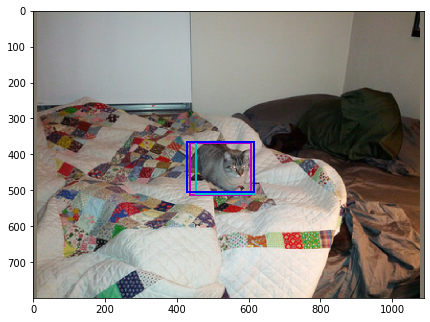

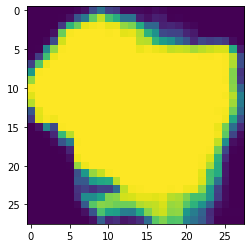

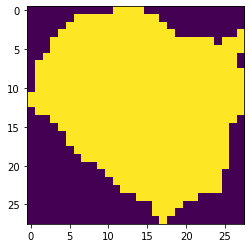

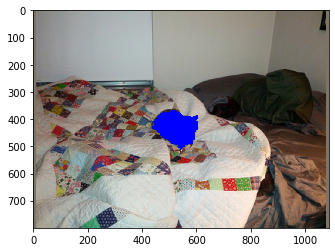

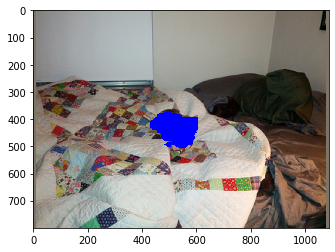

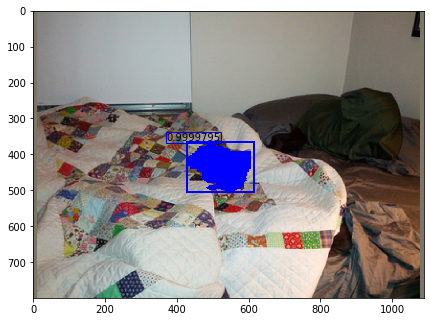

In [0]:
index = np.random.randint(len(dataloader_plot))
plot_test_mask(backbone=backbone, rpn = rpn, net=reload_model,
               mask_net = mask_model_, 
             device=device, 
             test_loader=dataloader_plot,i=index)

In [0]:
def calculate_precision_recall_object(predict, true_val):
  # predict = predict.squeeze(1).clone().detach()

  label_pred = torch.argmax(F.softmax(predict, dim = 1), 1)
  
  list_class = np.zeros([3, 2])
  true_val = true_val[:, 4]
  # debug()

  for i in range(1,4):
    true_index = torch.where(true_val == i)[0]
    if len(true_index) == 0:
      continue
    true_other_index = torch.where(true_val != i)[0]
    tp = (label_pred[true_index] == i).float().sum()
    fn = (label_pred[true_index] != i).float().sum()
    fp = (label_pred[true_other_index] == i).float().sum()
    prec = tp / (tp + fp)
    rec = tp /(fn + tp)
    list_class[i-1, 0] = prec
    list_class[i-1, 1] = rec

  return list_class

def calculate_metric(backbone, rpn, net, mask_net,device, test_loader, i):
  net.eval()
  prec_rec_mat = np.zeros([3, 2])
  list_preds = []
  list_labels = []
  
  with torch.no_grad():


      for i, (images, shape_list,targets, bbox, mask) in enumerate(test_loader):

        images = images[0].float().to(device)
        targets = targets[0].float().to(device)
        bbox = bbox[0].float().to(device)
        mask = mask[0].float().to(device)

        image_list = ImageList(images, shape_list)

        backout = backbone(images)

        align = ROIAlign(fpn = backout, device = device)
        rpn.eval()
        rpn_all = rpn(image_list, backout)
        reshaped_masks, mask_labels = format_masks(targets, mask, 
                                                  bbox, rpn_all[0][0],
                                                  device = device)
        

        

        all_proposals, all_labels, sampled_proposals, sampled_labels, sub_ind = format_labels_sample(targets, bbox, 
                                                                  rpn_all[0][0], 
                                                                  subSample = True,
                                                                  device = device)
        sampled_proposals, sampled_labels = all_proposals[:100], all_labels[:100]
        align_out = align.forward(sampled_proposals, step = 14)
        
        net_clas, net_reg = net(align_out)
        list_preds.append(net_clas.cpu())
        list_labels.append(sampled_labels.cpu())
        
        
  prec_rec_mat += calculate_precision_recall_object(torch.cat(list_preds), torch.cat(list_labels))

  return prec_rec_mat

In [0]:
calculate_metric(backbone=backbone, rpn = rpn, net=model,
               mask_net = mask_model, 
             device=device, 
             test_loader=dataloader_plot,i= 12)